## Credit Analysis
[Data Source](https://www.openml.org/d/31)

This is a dataset that contains different characteristics about individuals and whether they are "good" or "bad" customers for a bank. I want to explore this dataset a bit and then train a classification model that can predict whether an individual is a "good" or "bad" customer. 

### Import and Get Data

In [248]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
data = pd.read_csv("credit-g.csv")
data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [250]:
data.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

### Exploratory Data Analysis

Below, I plotted the distributions of the continuous features.

<AxesSubplot:xlabel='class', ylabel='count'>

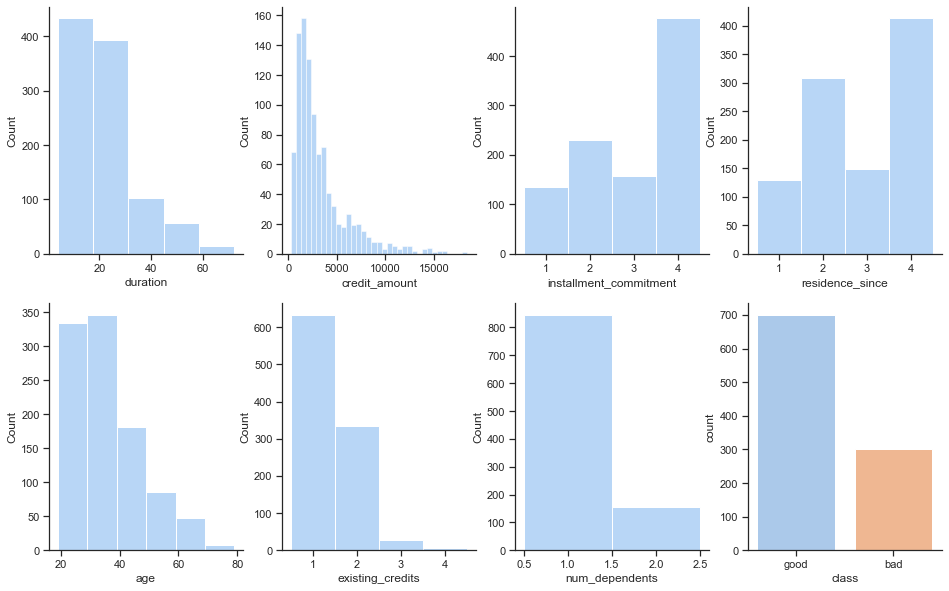

In [251]:
sns.set_theme(style="ticks", palette="pastel")

fig, ax = plt.subplots(2, 4, figsize=(16,10))

sns.histplot(ax=ax[0,0], data=data, x="duration", bins=5)
sns.despine(fig)

sns.histplot(ax=ax[0,1], data=data, x="credit_amount")

sns.histplot(ax=ax[0,2], data=data, x="installment_commitment", discrete=True)

sns.histplot(ax=ax[0,3], data=data, x="residence_since", discrete=True)

sns.histplot(ax=ax[1,0], data=data, x="age", binwidth=10)

sns.histplot(ax=ax[1,1], data=data, x="existing_credits", discrete=True)

sns.histplot(ax=ax[1,2], data=data, x="num_dependents", discrete=True)

sns.countplot(ax=ax[1,3], data=data, x="class")

The "class" target variable is imbalanced. I will take a subsample of the "good" class to match the count for the "bad" class.

I'm interested to see if there is any trend with credit amount and class.

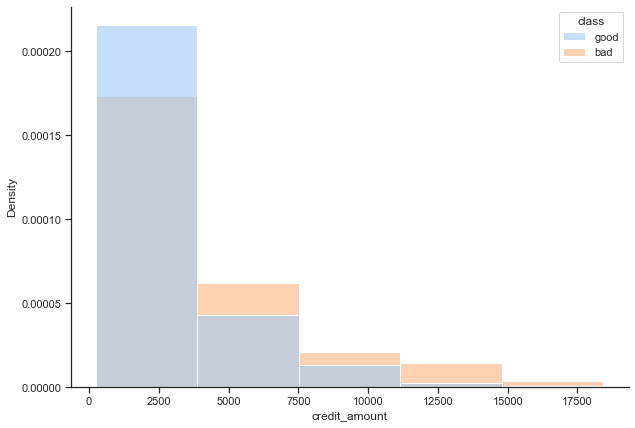

In [252]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=data, x="credit_amount", bins=5, hue="class", 
                stat="density", common_norm=False, alpha=0.6)
sns.despine(fig)

In [253]:
good_credit = data[data["class"]=="good"]["credit_amount"].mean()
bad_credit = data[data["class"]=="bad"]["credit_amount"].mean()

credit_amt_df = {"class":["good","bad"], "Credit Amount Mean":[good_credit,bad_credit]}
pd.DataFrame(credit_amt_df)

,class,Credit Amount Mean
0,good,2985.457143
1,bad,3938.126667


Those classified as "bad" tend to have higher credit_amounts (3939.13 and 2985.46 Deutsche Mark, respectively) as seen in the histogram and in the credit amount means found above.

What about men and women? Are either men or women more likely to be classified as "bad" according to this dataset? First I want to create a new column "gender" from the column "personal_status" which gives gender and marital status so that I just have the gender. 

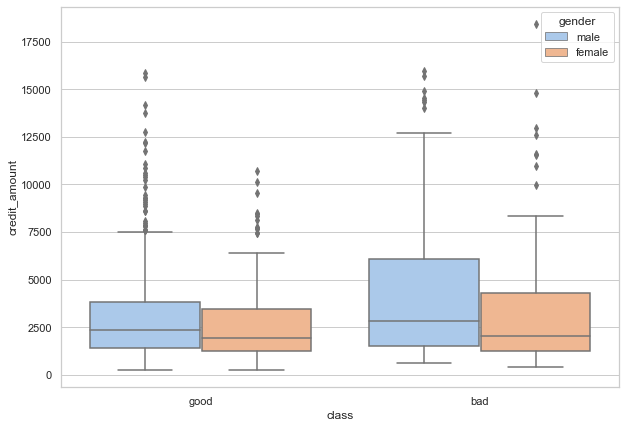

In [254]:
data["gender"] = data["personal_status"].str.extract("(^.+male)")
data["gender"] = data["gender"].str.lstrip("'")

fig = plt.figure(figsize=(10,7))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=data, x="class", y="credit_amount", hue="gender")


What is interesting to me is that for women and men, the median credit amount seems to be around the same amount whether classified as "good" or "bad". The "bad" class tends to have more extreme values in the positive direction.

I also want to visualize age and class status. I would suspect that those who are younger, and also maybe less experienced, are more likely to fall into the "bad" category.

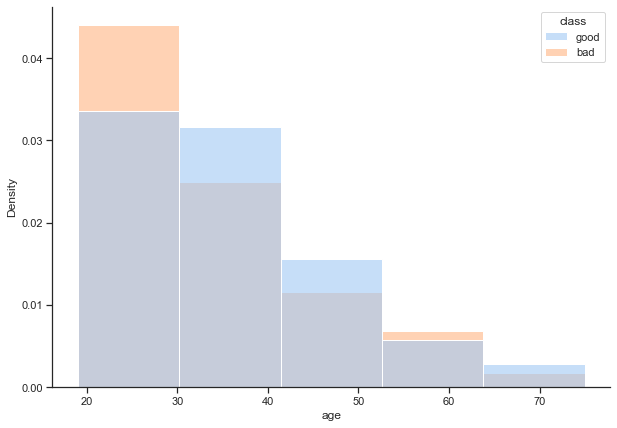

In [255]:
fig = plt.figure(figsize=(10,7))
sns.histplot(data=data, x="age", bins=5, hue="class", 
                stat="density", common_norm=False, alpha=0.6)
sns.despine(fig)

This seems to agree with my previous prediction that the "bad" class has a higher density of those in the 20-30 year old age group than the "good" class.

### Data Preprocessing

To preprocess the data, I will create dummy variables for the categorical variables. 

However, first I want to replace the "personal_status" variable with the "gender" variable I created earlier. Looking at the values for the "personal_status" variable below, I think it is better to model for men and women rather than having three different categories for men and one for women. 


In [256]:
data["personal_status"].unique()

array(["'male single'", "'female div/dep/mar'", "'male div/sep'",
       "'male mar/wid'"], dtype=object)

In [257]:
# Separate predictor from target
# target binary 0/1 with "bad" class as 1
y = data["class"]
y = pd.get_dummies(y)["bad"]
new_data = data.drop(columns=["personal_status","class"])

# get dummy variables
new_data = pd.get_dummies(data=new_data)
X = new_data

### Model Building

For fitting the training data, I want to try three different models and compare their mean cross-validation scores.
1. Logistic Regression
2. K Nearest Neighbors
3. Linear Support Vector Classification

To start, I will fit a logistic regression model using cross-validation to determine the best value for the parameter C, the regularization parameter. For all models I will scale the training data and test data using the scikit learn method StandardScalar().

**Note:** Larger values of C correspond to less regularization.

In [272]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=27, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

param_grid =  {'C': np.array([0.001,0.01,.1,1,100])}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, 
                    return_train_score=True)
grid.fit(X_train_scaled, y_train)
print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameter: {grid.best_params_}")



best mean cross-validation score: 0.75875
best parameter: {'C': 1.0}


Next I will fit a k-nearest neighbors model to the training data using cross-validation to determine the best k value.

In [263]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid =  {'n_neighbors': np.arange(1,30,2)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, 
                    return_train_score=True)
grid.fit(X_train_scaled, y_train)
print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameter: {grid.best_params_}")

best mean cross-validation score: 0.7425
best parameter: {'n_neighbors': 11}


Finally, I will fit a linear support vector classification model to the training data using cross-validation  to determine the best C parameter. 

In [265]:
from sklearn.svm import LinearSVC

param_grid =  {"C": np.array([.1,1,100])}
grid = GridSearchCV(LinearSVC(dual=False,max_iter=10000), param_grid=param_grid, cv=10, 
                    return_train_score=True)
grid.fit(X_train_scaled, y_train)
print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameter: {grid.best_params_}")

best mean cross-validation score: 0.74625
best parameter: {'C': 0.1}


Logistic regression, k-nearest neighbors, and linear SVC seem to produce about the same cross-validation scores for the training data, with logistic regression performing *slightly* better. I will use logistic regression as the final model to fit my test data and produce a confusion matrix of the results.  

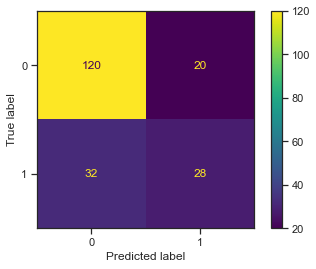

In [261]:
from sklearn.metrics import ConfusionMatrixDisplay

# fit the logistic regression model with the best C value found using GridSearchCV
lg = LogisticRegression(C=grid.best_params_['C'])
lg.fit(X_train_scaled,y_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

ConfusionMatrixDisplay.from_estimator(lg, X_test_scaled, y_test)

For the results, the model acccurately predits the "bad" class (label == 1) a little less than 50% of the time. In the dataset, the ratio of "good" to "bad" is 7:3, which explains the difficulty in accurately predicitng the "bad" class. 

In banking, it is better to have a lower threshold for the "bad" class, that is, it is better to classify a "good" customer as "bad" as opposed to classifying a "bad" customer as "good".

The confusion matrix above is classifying an observation into the "bad" category with the criteria P(Y=1|X) > 0.5. When wanting to predict the "bad" class more accurately at the expense of predicting the "good" class less accurately, adjusting this threshold to be lower can be helpful.

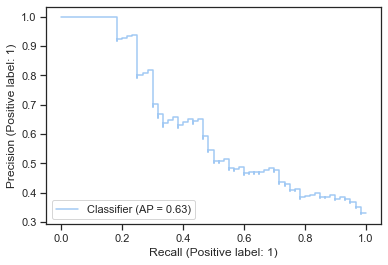

In [270]:
from sklearn.metrics import PrecisionRecallDisplay

y_pred = lg.predict_proba(X_test_scaled)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

Looking at the precision-recall curve above, as recall increases (less false negatives), precision decreases (more false positives). In this situation that this dataset describes, it would be better to increase recall at the expense of precision as mistaking bad customers for good customers would be more costly than mistaking a good customer for a bad one. 